<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import pytorch and make data agnostic code


In [2]:
import torch
from torch import nn
#version>=1.10.0 requried for this notebook
torch.__version__

'2.1.0+cu121'

In [3]:
#device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Getting data

In [4]:
#Data of commonly used dataset Food101 will be used. It has 1000 datapoints of 101 different food items
#will take 3 food items here. starting small to build the neural network, will then increase later

In [5]:
import requests
import zipfile
from pathlib import Path

#setup path to data folder
data_path= Path("data/")
image_path=data_path/"food_stuff"
#check if image folder exists or not, if not prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Didnt find {image_path}, creating...")
  image_path.mkdir(parents=True, exist_ok=True)
  #the datset that will be used is a formatted dataset being taken from a github file, in general, wont get such formatted data
  #download pizza, steak, sushi data in zip file
  with open(data_path/"food_stuff.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading data...")
    f.write(request.content)
  #unzip data
  with zipfile.ZipFile(data_path/"food_stuff.zip","r") as zip_ref:
    print("Unzipping food_stuff file...")
    zip_ref.extractall(image_path)

Didnt find data/food_stuff, creating...
Unzipping food_stuff file...


Visualizing how data is given

In [6]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There's {len(dirnames)} directories and {len(filenames)} images/files in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There's 2 directories and 0 images/files in 'data/food_stuff'.
There's 3 directories and 0 images/files in 'data/food_stuff/train'.
There's 0 directories and 72 images/files in 'data/food_stuff/train/sushi'.
There's 0 directories and 78 images/files in 'data/food_stuff/train/pizza'.
There's 0 directories and 75 images/files in 'data/food_stuff/train/steak'.
There's 3 directories and 0 images/files in 'data/food_stuff/test'.
There's 0 directories and 31 images/files in 'data/food_stuff/test/sushi'.
There's 0 directories and 25 images/files in 'data/food_stuff/test/pizza'.
There's 0 directories and 19 images/files in 'data/food_stuff/test/steak'.


In [8]:
#setting up training and testing data paths
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir, test_dir

(PosixPath('data/food_stuff/train'), PosixPath('data/food_stuff/test'))

See an image


Random Image Path:data/food_stuff/train/pizza/2154394.jpg
Image Class:pizza
Image Height:512
Image Width:512


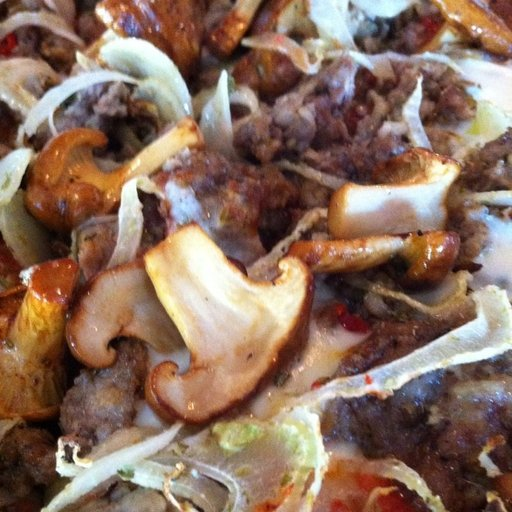

In [9]:
#Using PIL
import random
from PIL import Image
#setting seed
random.seed(59)
#getting all image paths (*= any combination)
image_path_list=list(image_path.glob("*/*/*.jpg"))
#get random image path
rand_img_path=random.choice(image_path_list)
#get image class from path name (image class name of directory where image is stored)
image_class=rand_img_path.parent.stem

#opening image
img=Image.open(rand_img_path)
#print metadata
print(f"Random Image Path:{rand_img_path}")
print(f"Image Class:{image_class}")
print(f"Image Height:{img.height}")
print(f"Image Width:{img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

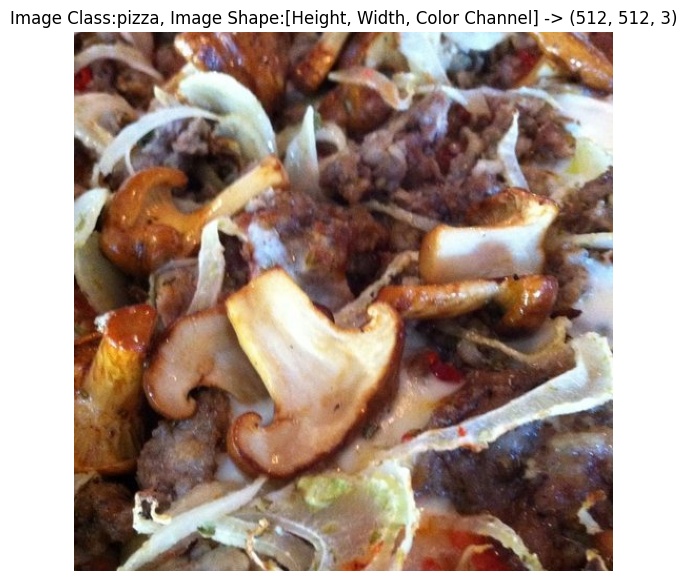

In [10]:
#Using Matplotlib.pyplot.imshow
import numpy as np
import matplotlib.pyplot as plt
#turning image to array
img_as_array=np.asarray(img)
#plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class:{image_class}, Image Shape:[Height, Width, Color Channel] -> {img_as_array.shape}")
plt.axis(False)

Tranforming Data and making appropriate dataset and dataloader

In [11]:
#we will convert image into datasets and dataloaders
#following datasets and functions are used for the corresponding problems
#Vision: torchvision.datasets
#Audio: torchaudio.datasets
#Text: torchtext.datasets
#Recommendation Systems: torchrec.datasets

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
#torchvision.transforms module contains functions for manipulating data according to our wishes.
#also its used for dataaugmentation: Augmenting data to make it harder for our model to learn(on purpose)

In [15]:
#Write transform for image, here we are first resizing image form (512,512) to (64,64), then randomly flipping them to their horizontal axis and then converting them into tensors
data_transform=transforms.Compose([
    #Resizing
    transforms.Resize(size=(64,64)),
    #Flipping images randomly(kind of data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),#p=Probability of flip
    #turning image into a tensor
    transforms.ToTensor()#also converts pixel value(ranging form 0 to 255) to be between 0.0 and 1.0
])

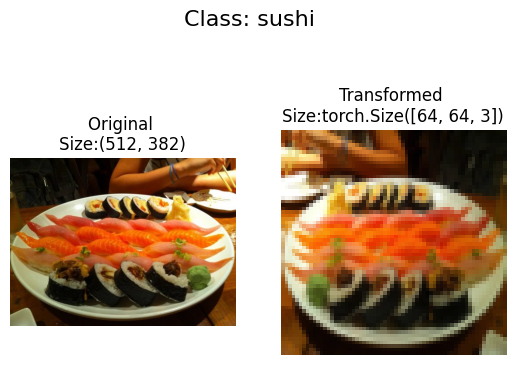

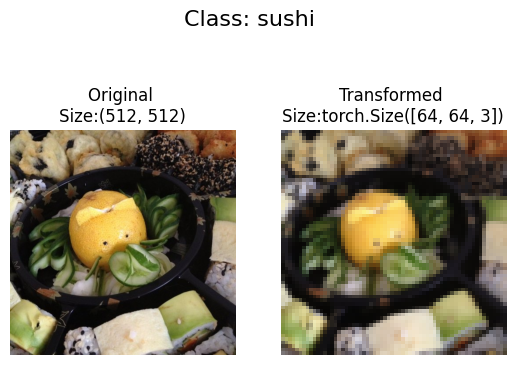

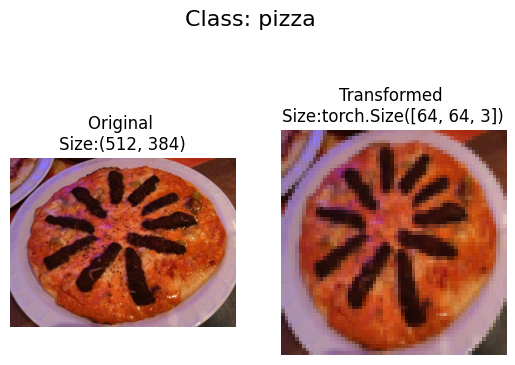

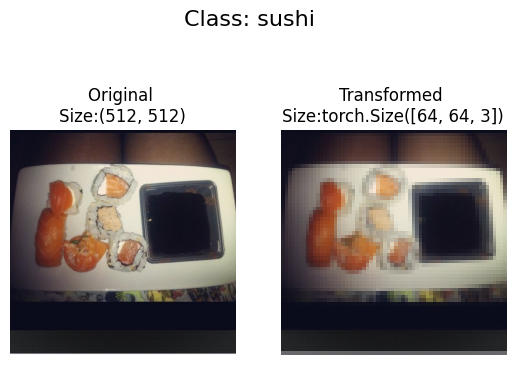

In [19]:
def plotting_transformed_image(image_paths, transform, n=3, seed=69):
  #will plot n random images from image path list
  #will plot original and trnasformed images side by side
  #Args:
  # image path(list): list of image paths
  #transform: transform to apply to images
  #number of images to plot
  #seed: random seed
  random.seed(seed)
  random_image_paths=random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax=plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize:{f.size}")
      ax[0].axis("off")

      #Transform and plot image
      #permute() will change shape to suit matplotlib
      #PyTorch default is [C,W,H] whereas Matplotlib is [H,W,C]
      transformed_image=transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize:{transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plotting_transformed_image(image_path_list,
                           transform=data_transform,
                           n=4)